/var/folders/n_/hjzxvjjs0fx2n1vxj4s_qbsm0000gn/T/ipykernel_19718/2200046475.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('best_model.pt', map

               precision    recall  f1-score   support

      Hip-Hop       0.98      0.97      0.97       338
International       0.97      0.97      0.97       365
   Electronic       0.95      0.97      0.96       329
         Folk       0.94      0.94      0.94       327
 Experimental       0.93      0.93      0.93       373
         Rock       0.96      0.96      0.96       374
          Pop       0.94      0.93      0.93       365
 Instrumental       0.96      0.95      0.95       324

     accuracy                           0.95      2795
    macro avg       0.95      0.95      0.95      2795
 weighted avg       0.95      0.95      0.95      2795



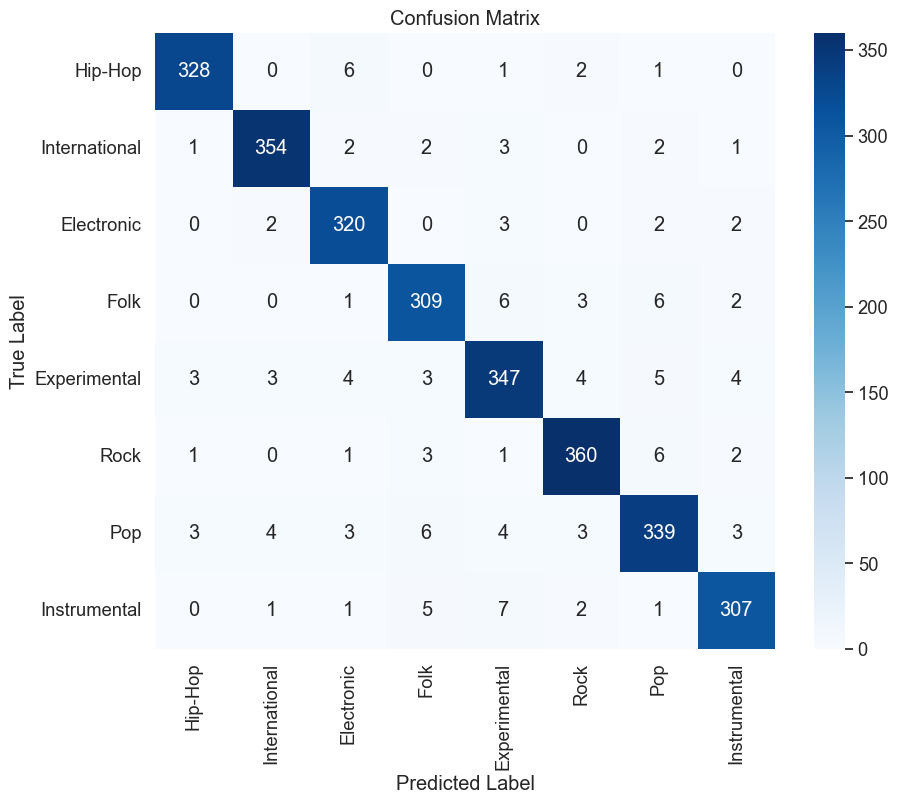

In [20]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set device configuration
device = torch.device('cpu')

# Define the conv layer and ResBlock
def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

def conv_layer(ni, nf, ks=3, stride=1, act=True):
    bn = nn.BatchNorm2d(nf)
    layers = [conv(ni, nf, ks, stride)]
    if act:
        layers.append(nn.ReLU(inplace=True))
    layers.append(bn)
    return nn.Sequential(*layers)

class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf, nf)
        self.conv2 = conv_layer(nf, nf, act=False)

    def forward(self, x):
        return x + self.conv2(self.conv1(x))

def conv_layer_averpl(ni, nf):
    return nn.Sequential(conv_layer(ni, nf), nn.AvgPool2d(2, 2))

# Define the complete CNN model
class MusicGenreCNN(nn.Module):
    def __init__(self):
        super(MusicGenreCNN, self).__init__()
        self.model = nn.Sequential(
            conv_layer_averpl(1, 64),
            ResBlock(64),
            conv_layer_averpl(64, 64),
            ResBlock(64),
            conv_layer_averpl(64, 128),
            ResBlock(128),
            conv_layer_averpl(128, 256),
            ResBlock(256),
            conv_layer_averpl(256, 512),
            ResBlock(512),
            nn.AdaptiveAvgPool2d((2, 2)),
            nn.Flatten(),
            nn.Linear(2048, 40),
            nn.Linear(40, 8)
        )

    def forward(self, x):
        return self.model(x)

# Reload and validate the model
model = MusicGenreCNN().to(device)
state_dict = torch.load('best_model.pt', map_location=device)
model.load_state_dict(state_dict)
model.eval()  # Set to evaluation mode

# Verify the dictionary for genres
dict_genres = {
    "Hip-Hop": 0,
    "International": 1,
    "Electronic": 2,
    "Folk": 3,
    "Experimental": 4,
    "Rock": 5,
    "Pop": 6,
    "Instrumental": 7  
}

# Dataset class
class TestDataset(Dataset):
    def __init__(self):
        self.x = torch.from_numpy(np.load('Training_Data/test_x.npy').astype(np.float32) / 255.0)
        self.y = torch.from_numpy(np.load('Training_Data/test_y.npy').reshape(-1).astype(np.int64))
        self.n_samples = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

# Initialize test dataset and dataloader
testDataset = TestDataset()
test_loader = DataLoader(dataset=testDataset, batch_size=1, shuffle=False)

# Evaluation
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.unsqueeze(1).to(device)  # Add channel dimension
        targets = targets.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_true.append(targets.item())
        y_pred.append(predicted.item())

# Print classification report
target_names = ["Hip-Hop", "International", "Electronic", "Folk", "Experimental", "Rock", "Pop", "Instrumental"]
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
from sklearn.metrics import accuracy_score
print("Accuracy score: {:.4f} % ".format(accuracy_score(y_true, y_pred)*100))

Accuracy score: 95.3131 % 
